In [7]:
%run ./ipy_setup.py
%matplotlib inline

from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Graphics import GenomeDiagram
from reportlab.lib.units import cm
from sklearn import mixture
import sklearn
import pysam
import math
from IPython import display
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy import stats
import itertools
import matplotlib.gridspec as gridspec

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 8)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'

read_bpos = dict()

def get_refmap(bamread):
    bpos = bamread.get_aligned_pairs(matches_only=True)
    positions = [i[0] for i in bpos]
    refpos =  [i[1] for i in bpos] # positions in reference
    refmap = dict(zip(refpos, positions))
    return refmap

def get_matched_bases_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outseq = [bamread.seq[refmap[i]] if i in refmap else 'N' for i in in_pos]
    outseq = ''.join(outseq)
    return outseq

def get_position_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outpos = None
    if in_pos in refmap:
        outpos = refmap[in_pos]
    return outpos

def reverse_compl(seq):
    translate = {'A':'T', 
                 'T':'A', 
                 'C':'G',
                 'G':'C', 
                 'N':'N'}

#%run ../scripts/greedy_partitioner.py

In [4]:
sequences = dict( (s.name, s) for s in ht.FastaReader("/hpc/users/neffr01/jason_new/contig_000000F.fa") )
block_reader = HapCutReader('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hapcut_qv13_mq10/hg002_hapcut_000000F.hapcut')

In [5]:
siteslist = []
pbar = ProgressBar(61100)
for line in open("/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_qv13_methyl_sig_sites-novariant-11mer.tsv", 'r'):
    pbar.animate()
    chrom, pos, mean1, mean2 = line.strip('\n').split(' ')
    pos, mean1, mean2 = int(pos), float(mean1), float(mean2)
    siteslist.append([chrom, pos, mean1, mean2])

[                  0%                  ]


In [23]:
blockpos = []
for i in block_reader.blocks:
    block = block_reader.loc(i)
    blockpos.append([i, block.chrom, block.start, block.end])

In [24]:
def getBlocks(in_start, in_end):
    return [b[0] for b in blockpos if ((b[2] < in_end) & (b[2] > in_start)) \
            | ((b[3] > in_start) & (b[3] < in_end)) | ((b[2] < in_start) & (b[3] > in_end))]

In [12]:
bam_fp = pysam.AlignmentFile("/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hapcut_qv13_mq10/hg002.000000F.qv13mq10.redo.merged.ann.bam", "rb")
#out_fp = pysam.AlignmentFile("~/jason_new/hapcut_outputs/hg002_re_000000F/hg002_methyl_phased-from-trio-data_000000F.bam", 'wb')
#out_predict = open("/hpc/users/neffr01/jason_new/methyl_predict/hg002_methyl_denovo_vs_truth.tsv", "w")
predictions = []
#pbar = ProgressBar(170000)
for bid, block in block_reader.blocks.iteritems():
    for read in bam_fp.fetch(region="000000F", start=block.start, end=block.end):
        #pbar.animate()
        rstart, rend = read.pos, read.aend
        sigoverlap = [i for i in siteslist if (i[1] <= rend) & (i[1] >= rstart)]
        if len(sigoverlap) == 0:
            continue
        refmap = get_refmap(read)
        ipd_values = [int(i) for i in read.get_tag('ip').strip('S').split(',')]
        hap = int(read.get_tag('ZH').split(";")[0].split(",")[1])
        #hap = read.get_tag('ZH')
        pv = read.get_tag('ZV')
        res = []
        for row in sigoverlap:
            refpos = row[1]
            basepos = get_position_in_read(read, refpos, refmap)
            if basepos==None: continue
            ipd_value = np.log(ipd_values[basepos])
            #motif = refseq[refpos-5-(rstart):refpos+6-rstart]
            #ref_3mer = motif[4:7]
            #read_3mer = get_matched_bases_in_read(read, range(refpos-1,refpos+2), refmap)
            #if ref_3mer != read_3mer: continue
            res.append([abs(row[2]-ipd_value), abs(row[3]-ipd_value)])
        if res != []:
            #print read.qname
            hap1_res = sum([i[0] for i in res])
            hap2_res = sum([i[1] for i in res])
            predict_hap = None
            if hap1_res > hap2_res:
                predict_hap = 2
            else:
                predict_hap = 1
            #print "Predicted:\t", predict_hap, "actual:\t", hap
            predictions.append([bid, rstart, rend, predict_hap, hap, len(res), pv, hap1_res, hap2_res, read.alen])
            print >>sys.stdout, bid, rstart, rend, predict_hap, hap, len(res), pv, hap1_res, hap2_res, read.alen
            #out_predict.flush()
    break

10240 13755339 13772408 1 1 28 2 13.0761696605 23.6125759109 17069
10240 13757108 13775488 2 0 32 4 23.122482696 21.9446194982 18380
10240 13758544 13771281 2 2 25 2 25.6424131138 15.0036853965 12737
10240 13758544 13771266 2 2 24 2 21.6229980645 10.172448682 12722
10240 13760010 13773311 1 1 28 2 14.8463497579 31.7877540401 13301
10240 13760027 13775408 1 0 34 4 30.1826750732 31.364969582 15381
10240 13760057 13771278 2 2 25 2 26.6634537068 11.3200786615 11221
10240 13760441 13773992 2 0 32 4 36.8389119917 35.0555721894 13551
10240 13760445 13773157 2 2 29 2 27.6812561061 14.2832296778 12712
10240 13760506 13772490 1 1 28 2 19.5182636828 29.0035998851 11984
10240 13760714 13773594 2 0 29 4 29.4344357058 26.6369563983 12880
10240 13760913 13774526 1 1 34 2 15.4322818564 23.2198401927 13613
10240 13761376 13773184 2 2 29 2 19.7954266019 15.3167837765 11808
10240 13761402 13773128 2 2 28 2 27.5494377155 18.6814011713 11726
10240 13761592 13773493 1 1 28 2 10.5610483412 22.4845799173 1190

In [26]:
bam_fp = pysam.AlignmentFile("/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hg002_000000F.new.merged.bam.rg.bam", "rb")
#out_fp = pysam.AlignmentFile("~/jason_new/hapcut_outputs/hg002_re_000000F/hg002_methyl_phased-from-trio-data_000000F.bam", 'wb')
#out_predict = open("/hpc/users/neffr01/jason_new/methyl_predict/hg002_methyl_denovo_vs_truth.tsv", "w")
predictions = []
#pbar = ProgressBar(170000)
for bid, block in block_reader.blocks.iteritems():
    for read in bam_fp.fetch(region="000000F", start=13805564, end=13827957):
        #pbar.animate()
        rstart, rend = read.pos, read.aend
        sigoverlap = [i for i in siteslist if (i[1] <= rend) & (i[1] >= rstart)]
        if len(sigoverlap) == 0:
            continue
        refmap = get_refmap(read)
        ipd_values = [int(i) for i in read.get_tag('ip').strip('S').split(',')]
        #hap = int(read.get_tag('ZH').split(";")[0].split(",")[1])
        #hap = read.get_tag('ZH')
        #pv = read.get_tag('ZV')
        hap = None
        pv = None
        res = []
        for row in sigoverlap:
            refpos = row[1]
            basepos = get_position_in_read(read, refpos, refmap)
            if basepos==None: continue
            ipd_value = np.log(ipd_values[basepos])
            #motif = refseq[refpos-5-(rstart):refpos+6-rstart]
            #ref_3mer = motif[4:7]
            #read_3mer = get_matched_bases_in_read(read, range(refpos-1,refpos+2), refmap)
            #if ref_3mer != read_3mer: continue
            res.append([abs(row[2]-ipd_value), abs(row[3]-ipd_value)])
        if res != []:
            #print read.qname
            hap1_res = sum([i[0] for i in res])
            hap2_res = sum([i[1] for i in res])
            predict_hap = None
            if hap1_res > hap2_res:
                predict_hap = 2
            else:
                predict_hap = 1
            #print "Predicted:\t", predict_hap, "actual:\t", hap
            predictions.append([bid, rstart, rend, predict_hap, hap, len(res), pv, hap1_res, hap2_res, read.alen])
            print >>sys.stdout, bid, getBlocks(rstart, rend), rstart, rend, predict_hap, hap, len(res), pv, hap1_res, hap2_res, read.alen
            #out_predict.flush()
    break

10240 [10240] 13789857 13809311 1 None 109 None 77.9902742732 113.750724016 19454
10240 [10240] 13792974 13810305 1 None 100 None 58.1032843819 91.0776549739 17331
10240 [10240] 13794260 13808825 1 None 92 None 61.7734119277 113.674870046 14565
10240 [10240] 13794540 13810320 1 None 98 None 62.3541191013 126.747291054 15780
10240 [10240] 13794804 13806072 1 None 76 None 61.3561188172 110.087747633 11268
10240 [10240] 13794884 13806506 1 None 84 None 54.6924404966 90.494537802 11622
10240 [10240] 13794968 13806499 1 None 80 None 55.5535189379 100.759343541 11531
10240 [10240] 13794975 13806043 1 None 71 None 60.2899056266 70.5226363109 11068
10240 [10240] 13795072 13811989 1 None 104 None 70.2271324301 152.857763031 16917
10240 [10240] 13795092 13807709 1 None 85 None 63.5588626661 121.886104586 12617
10240 [10240] 13795330 13806470 1 None 79 None 46.6166470054 94.1946655285 11140
10240 [10240] 13795816 13809224 1 None 89 None 52.4763214263 114.250888897 13408
10240 [10240] 13795912 138

n= 432


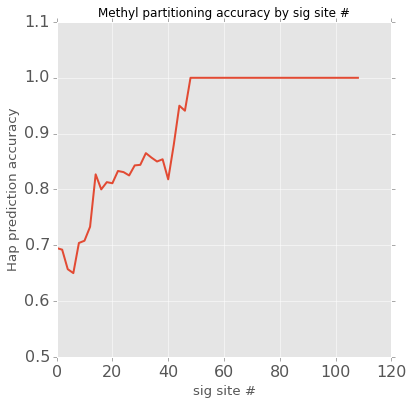

In [15]:
rcParams['figure.figsize'] = (6, 6)
rcParams['axes.titlesize'] = 12
pltarr = []
t = len(predictions)
print "n=", len(predictions)
for var in range(0,150,2):
    predcheck = [i for i in predictions if (i[5] > var) & (i[5] < var+10)]
    if len(predcheck) == 0:
        break
    acc = round(np.mean([1 if i[3] == i[4] else 0 for i in predcheck]), 3)
    n = len(predcheck)
    pltarr.append([var, acc, n])
    #print "partition variants >=", var, "prediction acc:", acc , "n %", n/float(t)*100
plt.title("Methyl partitioning accuracy by sig site #")
plt.plot([i[0] for i in pltarr], [i[1] for i in pltarr])
plt.ylim([0.5,1.1])
plt.xlabel("sig site #", fontsize='small')
plt.ylabel("Hap prediction accuracy", fontsize='small')
plt.show()

n= 432


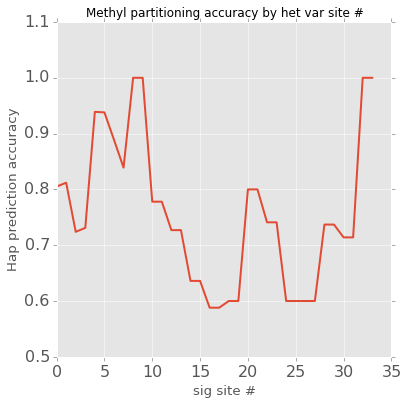

In [21]:
rcParams['figure.figsize'] = (6, 6)
rcParams['axes.titlesize'] = 12
pltarr = []
t = len(predictions)
print "n=", len(predictions)
for var in range(0,50,1):
    predcheck = [i for i in predictions if (i[6] > var) & (i[6] < var+5)]
    if len(predcheck) == 0:
        break
    acc = round(np.mean([1 if i[3] == i[4] else 0 for i in predcheck]), 3)
    n = len(predcheck)
    pltarr.append([var, acc, n])
    #print "partition variants >=", var, "prediction acc:", acc , "n %", n/float(t)*100
plt.title("Methyl partitioning accuracy by het var site #")
plt.plot([i[0] for i in pltarr], [i[1] for i in pltarr])
plt.ylim([0.5,1.1])
plt.xlabel("sig site #", fontsize='small')
plt.ylabel("Hap prediction accuracy", fontsize='small')
plt.show()